In [2]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NeighbourhoodCleaningRule

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn import metrics
import xgboost as xgb

from imblearn.ensemble import BalancedBaggingClassifier

import graphviz
import plotly.graph_objects as go
import plotly.offline as py

In [3]:
from plot_learning_curve import plot_learning_curve

ModuleNotFoundError: No module named 'plot_learning_curve'

In [4]:
import warnings

In [5]:
def feature_importance_scatter_plot(model_name,model_feature_importance,feature_data):
    # Scatter plot 
    trace = go.Scatter(
        y = model_feature_importance,
        x = feature_data.columns,
        mode='markers',
        marker=dict(
            sizemode = 'diameter',
            sizeref = 1,
            size = 25,
    #       size= feature_dataframe['AdaBoost feature importances'].values,
            #color = np.random.randn(500), #set color equal to a variable
            color = model_feature_importance,
            colorscale='Portland',
            showscale=True
        ),
        text = feature_data.columns
    )
    data = [trace]

    layout= go.Layout(
        autosize= True,
        title= model_name,
        hovermode= 'closest',
    #     xaxis= dict(
    #         title= 'Pop',
    #         ticklen= 5,
    #         zeroline= False,
    #         gridwidth= 2,
    #     ),
        yaxis=dict(
            title= 'Feature Importance',
            ticklen= 5,
            gridwidth= 2
        ),
        showlegend= False
    )
    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig,filename='scatter2010')

In [6]:
def model_describe(y_test,y_pred,y_pred_prob):
    print('Model Summary Report')
    print(metrics.classification_report(y_test,y_pred))
    print('\nAUC score',metrics.roc_auc_score(y_test,y_pred_prob))
    fpr,tpr,threshold = metrics.roc_curve(y_test,y_pred_prob)
    plt.figure()
    plt.plot(fpr,tpr)
    plt.title('ROC Curve')
    plt.show()

In [7]:
def model_train(x_train, x_test, y_train, y_test, model_func, parameters_grid=None):

    if parameters_grid:
        model = model_func()

        gridSearch = GridSearchCV(model,parameters_grid,cv = 10, scoring=roc_auc_weighted)
        gridSearch.fit(x_train,y_train)
    #     print(gridSearch.best_score_)
        best_params = gridSearch.best_params_
        print(best_params)

        model = model_func()
        model.set_params(**gridSearch.best_params_)
    else:
        model = model_func()

    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    try:
        y_pred_prob = model.predict_proba(x_test)[:,1]
    except:
        y_pred_prob = y_pred
    print('In-Sample Accuracy: ', round(model.score(x_train, y_train) * 100, 2), '%')
    print('Out-of-Sample Accuracy: ', round(model.score(x_test, y_test) * 100, 2), '%', '\n')
    model_describe(y_test,y_pred,y_pred_prob)
    
    return model

In [8]:
def my_evaluation(model_func, parameters_grid, parameters_grid_two=None):
    global c_X_test
    global nc_X_test
    global c_Y_test
    global nc_Y_test
    global c_X_train
    global nc_X_train
    global c_Y_train
    global nc_Y_train
    
    if parameters_grid_two == None:
        parameters_grid_two = parameters_grid
    nc_model = model_train(nc_X_train, nc_X_test, nc_Y_train, nc_Y_test, model_func, parameters_grid)
    c_model = model_train(c_X_train, c_X_test, c_Y_train, c_Y_test, model_func, parameters_grid_two)
    
    comb_result(nc_model, c_model)
    
    return nc_model, c_model

In [9]:
def get_pred_prob(model, x_test):
    y_pred = model.predict(x_test)
    try:
        y_pred_prob = model.predict_proba(x_test)[:,1]
    except:
        y_pred_prob = y_pred
    return y_pred_prob

In [10]:
def comb_result(nc_model, c_model):
        
    global c_X_test
    global nc_X_test
    global c_Y_test
    global nc_Y_test
    
    c_y_pred = c_model.predict(c_X_test)
    c_y_pred_prob = get_pred_prob(c_model, c_X_test)
    
    nc_y_pred = nc_model.predict(nc_X_test)
    nc_y_pred_prob = get_pred_prob(nc_model, nc_X_test)
    
    Y_test = pd.concat([c_Y_test, nc_Y_test]).values
    global a
    global b
    a = c_y_pred
    b = nc_y_pred
    y_pred = list(c_y_pred) + list(nc_y_pred)
    y_pred_prob = list(c_y_pred_prob) + list(nc_y_pred_prob)
    
    model_describe(Y_test,y_pred,y_pred_prob)

In [11]:
smote = SMOTE()
ncr = NeighbourhoodCleaningRule()

sns.set()

warnings.filterwarnings('ignore')

In [12]:
roc_auc_weighted = metrics.make_scorer(metrics.roc_auc_score, average='micro')

In [13]:
model_list = [LogisticRegression,SVC,RandomForestClassifier,KNeighborsClassifier,GaussianNB,Perceptron,SGDClassifier,DecisionTreeClassifier]

###  Load Data

In [43]:
cluster_path = '../data_stage2/kmeans.csv'

# new feature after svd reducing dimention
feature_path = '../data_stage2/new_svd.csv'

# new feature
# feature_path = '../data_stage2/new_feature.csv'

In [44]:
cluster_df = pd.read_csv(cluster_path ,index_col = 0).drop(['status'], axis=1)
data_df =  pd.read_csv(feature_path, index_col = 0)

In [45]:
new_columns = list(map(lambda x:"V"+str(x), data_df.columns[:-1])) + [data_df.columns[-1]]
data_df.columns = new_columns

In [46]:
cluster_df.cluster.value_counts()

0    12500
1     2220
Name: cluster, dtype: int64

Normalization

In [47]:
initial_status = data_df.status
data_df = (data_df - data_df.mean())/data_df.std()
data_df['status'] = initial_status

In [52]:
connect_data = data_df.loc[cluster_df.cluster == 0]
nonconnect_data = data_df.loc[cluster_df.cluster == 1]
connect_data.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,status
X1,,,,,,,,,,,,,,,,,
18,-0.280858,-0.194292,-0.355112,-0.200142,-0.491025,-0.140613,-0.102025,-0.156227,-0.135982,0.220176,0.005598,-0.564319,0.156146,0.137877,-0.186128,0.344966,1
20,-2.120269,0.080612,0.392281,0.304572,-0.836248,-0.486866,0.309136,-0.340658,0.394396,-0.464727,-1.302648,0.716275,0.264519,0.554698,0.054239,0.371146,1
21,-0.775722,3.269094,0.032368,-0.239906,1.691056,-0.766862,-0.978961,-0.264682,-1.106567,-1.418420,-0.080989,0.240629,-2.147225,-4.051883,1.708042,-3.175159,1
23,-0.180134,-0.958647,-0.316069,0.195091,-0.581218,0.421693,-0.426623,-0.495539,-0.777040,-0.569108,-1.475367,0.603104,-0.519481,-1.038040,0.076367,0.628857,1
26,-0.031816,-0.206955,-0.626748,-0.710831,-0.126367,-0.102961,0.206608,0.444335,0.488529,0.276254,0.239432,-0.494560,0.416392,0.014965,-0.167462,0.252133,1


In [53]:
print('connect_data.shape', connect_data.shape)
print('nonconnect_data.shape', nonconnect_data.shape)
print('connect_data.status.value_counts()\n', connect_data.status.value_counts())
print('nonconnect_data.status.value_counts()\n', nonconnect_data.status.value_counts())

connect_data.shape (12500, 17)
nonconnect_data.shape (2220, 17)
connect_data.status.value_counts()
 0    11781
1      719
Name: status, dtype: int64
nonconnect_data.status.value_counts()
 0    1359
1     861
Name: status, dtype: int64


Split

In [54]:
c_X_train,c_X_test,c_Y_train,c_Y_test = train_test_split(connect_data.drop(['status'], axis=1),connect_data.status,test_size = 0.3,random_state = 0) 
nc_X_train,nc_X_test,nc_Y_train,nc_Y_test = train_test_split(nonconnect_data.drop(['status'], axis=1),nonconnect_data.status,test_size = 0.3,random_state = 0) 

In [55]:
c_Y_test.shape

(3750,)

In [56]:
nc_Y_test.shape

(666,)

In [57]:
c_flag = 370
nc_flag = 2100

In [58]:
nc_X_train.shape

(1554, 16)

In [59]:
c_X_train = pd.concat([c_X_train, c_X_test.iloc[:c_flag]])
c_Y_train = pd.concat([c_Y_train, c_Y_test.iloc[:c_flag]])

nc_X_train = pd.concat([nc_X_train, nc_X_test.iloc[:nc_flag]])
nc_Y_train = pd.concat([nc_Y_train, nc_Y_test.iloc[:nc_flag]])

Resample

In [60]:
nc_Y_train.value_counts()

0    1359
1     861
Name: status, dtype: int64

In [61]:
nc_X_train, nc_Y_train = ncr.fit_sample(nc_X_train, nc_Y_train)

In [62]:
nc_Y_train.value_counts()

1    861
0    662
Name: status, dtype: int64

## Single Model

### Logistic Regression

In [63]:
logsitcregressionCV_parameters_grid = {
    'class_weight':['balanced'],
    'penalty':['l1','l2','elasticnet'],
    'solver':['liblinear','saga','lbfgs'],
#     'Cs':np.arange(0.5,2,0.2),
    'max_iter' : [500],
    'scoring': [roc_auc_weighted]
}

{'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l2', 'scoring': make_scorer(roc_auc_score, average=micro), 'solver': 'lbfgs'}
In-Sample Accuracy:  82.77 %
Out-of-Sample Accuracy:  72.36 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.83      0.67      0.74       409
           1       0.59      0.78      0.68       257

    accuracy                           0.71       666
   macro avg       0.71      0.72      0.71       666
weighted avg       0.74      0.71      0.71       666


AUC score 0.7858114600477581


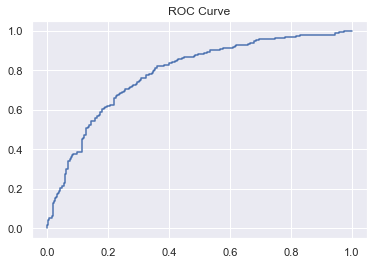

{'class_weight': 'balanced', 'max_iter': 500, 'penalty': 'l1', 'scoring': make_scorer(roc_auc_score, average=micro), 'solver': 'saga'}
In-Sample Accuracy:  66.7 %
Out-of-Sample Accuracy:  65.98 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.97      0.69      0.81      3538
           1       0.11      0.63      0.19       212

    accuracy                           0.69      3750
   macro avg       0.54      0.66      0.50      3750
weighted avg       0.92      0.69      0.77      3750


AUC score 0.6966599827212901


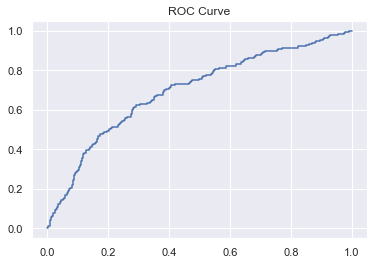

Model Summary Report
              precision    recall  f1-score   support

           0       0.95      0.69      0.80      3947
           1       0.21      0.71      0.33       469

    accuracy                           0.69      4416
   macro avg       0.58      0.70      0.56      4416
weighted avg       0.87      0.69      0.75      4416


AUC score 0.758321750399618


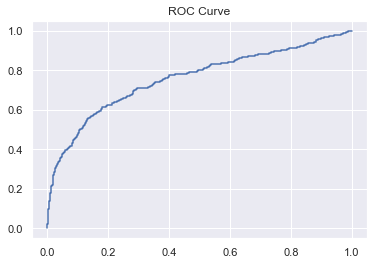

In [64]:
nc_lr_model, c_lr_model = my_evaluation(LogisticRegressionCV, logsitcregressionCV_parameters_grid)

### SVC Regression

In [65]:
svc_regression_parameters_grid={
#     'C':np.arange(0.5,2,0.2),
#     'kernel':['linear','poly','rbf','sigmoid'],
#     'gamma':['scale','auto'],
    'kernel':['rbf'],
    'gamma':['auto'],
    'class_weight':['balanced']
}

{'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
In-Sample Accuracy:  90.15 %
Out-of-Sample Accuracy:  75.38 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.89      0.68      0.77       409
           1       0.63      0.86      0.73       257

    accuracy                           0.75       666
   macro avg       0.76      0.77      0.75       666
weighted avg       0.79      0.75      0.76       666


AUC score 0.7742049032945497


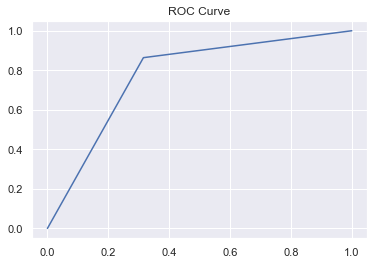

{'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}
In-Sample Accuracy:  76.97 %
Out-of-Sample Accuracy:  74.05 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.97      0.75      0.84      3538
           1       0.12      0.59      0.20       212

    accuracy                           0.74      3750
   macro avg       0.55      0.67      0.52      3750
weighted avg       0.92      0.74      0.81      3750


AUC score 0.6695993365828684


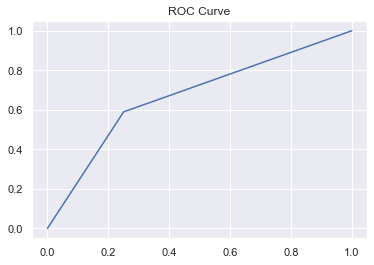

Model Summary Report
              precision    recall  f1-score   support

           0       0.96      0.74      0.84      3947
           1       0.25      0.74      0.38       469

    accuracy                           0.74      4416
   macro avg       0.61      0.74      0.61      4416
weighted avg       0.89      0.74      0.79      4416


AUC score 0.7413573667728532


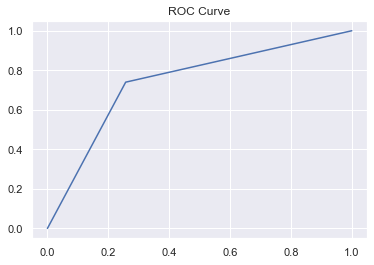

In [66]:
nc_svc_model, c_svc_model= my_evaluation(SVC, svc_regression_parameters_grid)

### Decision Tree

In [543]:
decision_parameters_grid = {
    'max_depth':np.arange(3,20,2),
#     'max_depth':[15],
    'class_weight':['balanced'],
    'max_features':['auto','sqrt','log2']
}

{'class_weight': 'balanced', 'max_depth': 7, 'max_features': 'auto'}
In-Sample Accuracy:  70.96 %
Out-of-Sample Accuracy:  64.91 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      3477
           1       0.11      0.68      0.18       211

    accuracy                           0.65      3688
   macro avg       0.54      0.66      0.48      3688
weighted avg       0.92      0.65      0.74      3688


AUC score 0.6647870160990231


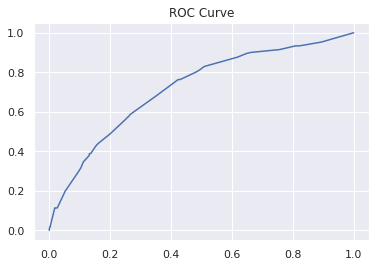

{'class_weight': 'balanced', 'max_depth': 5, 'max_features': 'sqrt'}
In-Sample Accuracy:  79.04 %
Out-of-Sample Accuracy:  73.36 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.81      0.77      0.79       473
           1       0.61      0.67      0.64       259

    accuracy                           0.73       732
   macro avg       0.71      0.72      0.71       732
weighted avg       0.74      0.73      0.74       732


AUC score 0.7187548466618234


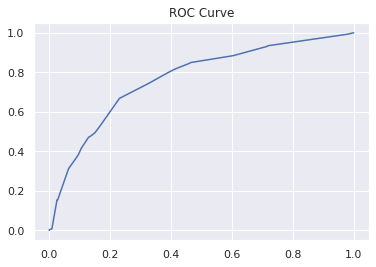

Model Summary Report
              precision    recall  f1-score   support

           0       0.94      0.66      0.78      3950
           1       0.19      0.67      0.30       470

    accuracy                           0.66      4420
   macro avg       0.57      0.67      0.54      4420
weighted avg       0.86      0.66      0.73      4420


AUC score 0.6681201185025586


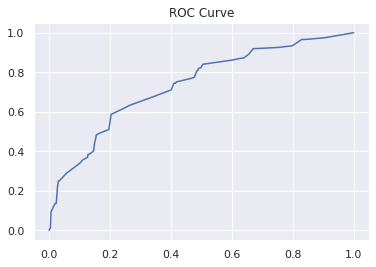

In [544]:
nc_dt_model, c_dt_model = my_evaluation(DecisionTreeClassifier, decision_parameters_grid)

## Combine The Single Model

In [614]:
nc_model = VotingClassifier(estimators=[('lr', nc_lr_model), ('svc', nc_svc_model), ('dt', nc_dt_model)], weights=[1,2,1], voting='hard')
nc_model.fit(nc_X_train, nc_Y_train)

nc_y_pred = nc_model.predict(nc_X_test)
nc_y_pred_prob = get_pred_prob(nc_model, nc_X_test)

In [615]:
c_model = VotingClassifier(estimators=[('lr', c_lr_model), ('svc', c_svc_model), ('dt', c_dt_model)],weights=[1,2,1], voting='hard')
c_model.fit(c_X_train, c_Y_train)

c_y_pred = c_model.predict(c_X_test)
c_y_pred_prob = get_pred_prob(c_model, c_X_test)

Model Summary Report
              precision    recall  f1-score   support

           0       0.97      0.75      0.85      3477
           1       0.14      0.68      0.23       211

    accuracy                           0.74      3688
   macro avg       0.56      0.71      0.54      3688
weighted avg       0.93      0.74      0.81      3688


AUC score 0.7133233012606881


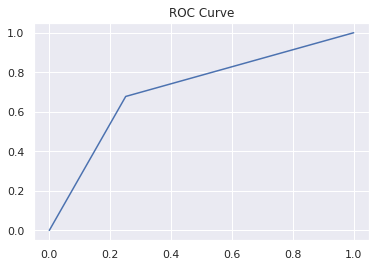

In [616]:
model_describe(nc_Y_test,nc_y_pred,nc_y_pred_prob)

Model Summary Report
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       473
           1       0.67      0.71      0.69       259

    accuracy                           0.77       732
   macro avg       0.75      0.76      0.75       732
weighted avg       0.78      0.77      0.77       732


AUC score 0.7581444325630373


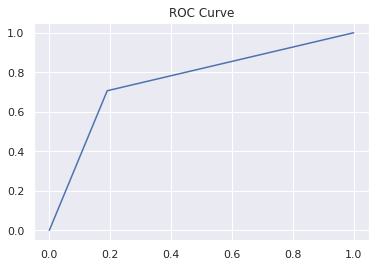

In [617]:
model_describe(c_Y_test,c_y_pred,c_y_pred_prob)

In [618]:
Y_test = list(c_Y_test) + list(nc_Y_test)
y_pred = list(c_y_pred) + list(nc_y_pred)
y_pred_prob = list(c_y_pred_prob) + list(nc_y_pred_prob)

Model Summary Report
              precision    recall  f1-score   support

           0       0.95      0.76      0.84      3950
           1       0.25      0.69      0.37       470

    accuracy                           0.75      4420
   macro avg       0.60      0.72      0.61      4420
weighted avg       0.88      0.75      0.79      4420


AUC score 0.7249097764610827


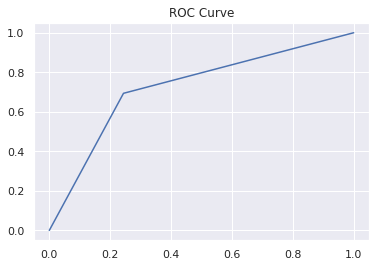

In [619]:
model_describe(Y_test,y_pred,y_pred_prob)

## Ensembl Learning

### Adaboost

In [545]:
adaboost_tree_parameters_grid={
    'base_estimator': [
        DecisionTreeClassifier(max_depth=6, min_samples_split=20, min_samples_leaf=5, class_weight='balanced')
    ],
    'algorithm' : ["SAMME"],
#     'n_estimators' : [30,50,100,200,350,500,600],
#     'learning_rate' : [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
    'n_estimators':[300], #best parameter
    'learning_rate': [0.1] #best parameter
}

{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'learning_rate': 0.1, 'n_estimators': 300}
In-Sample Accuracy:  78.8 %
Out-of-Sample Accuracy:  72.91 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.98      0.73      0.84      3477
           1       0.14      0.73      0.24       211

    accuracy                           0.73      3688
   macro avg       0.56      0.73      0.54      3688
weighted avg       0.93      0.73      0.80      3688


AUC score 0.7294673051208551


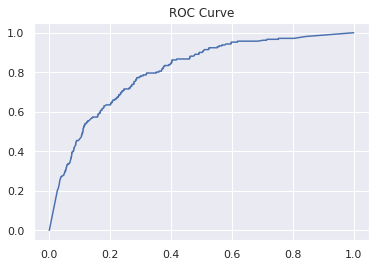

{'algorithm': 'SAMME', 'base_estimator': DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best'), 'learning_rate': 0.1, 'n_estimators': 300}
In-Sample Accuracy:  90.75 %
Out-of-Sample Accuracy:  82.24 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.88      0.85      0.86       473
           1       0.73      0.78      0.76       259

    accuracy                           0.82       732
   macro avg       0.80      0.81      0.81       732
weighted avg       0.83      0.82      0.82       732


AUC score 0.8127943709339058


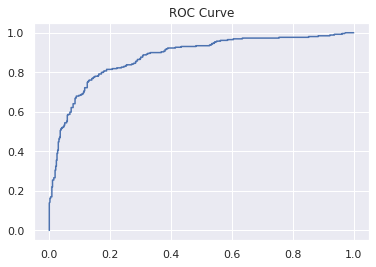

Model Summary Report
              precision    recall  f1-score   support

           0       0.96      0.74      0.84      3950
           1       0.26      0.76      0.39       470

    accuracy                           0.74      4420
   macro avg       0.61      0.75      0.61      4420
weighted avg       0.89      0.74      0.79      4420


AUC score 0.7502423915970913


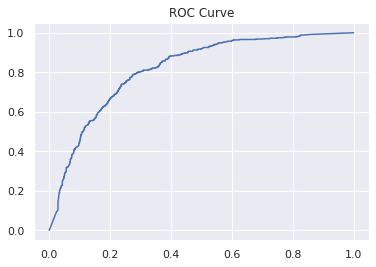

In [546]:
nc_ada_tree_model, c_ada_tree_model = my_evaluation(AdaBoostClassifier, adaboost_tree_parameters_grid)

### Random Forest

In [590]:
randomforest_parameters_grid = {
                'class_weight':['balanced'],
#                 'n_estimators':[300,400,500,600,700],
                'n_estimators':[400],
    #n_estimator  ;100 best for connect
#                 'max_features': ['auto', 'sqrt'],
                'max_features': ['auto'],
#                 'max_depth ':[1,5,10,15,20,30,40,50],
                'max_depth':[7],
#                 'min_samples_split' : [2, 5, 10],
#                 'min_samples_leaf' : [1, 2, 4],
#                 'bootstrap' : [True, False]
                'min_samples_split' : [2],
                'min_samples_leaf' : [2],
                'bootstrap' : [True],
}

{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
In-Sample Accuracy:  77.43 %
Out-of-Sample Accuracy:  73.35 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.97      0.74      0.84      3477
           1       0.12      0.61      0.21       211

    accuracy                           0.73      3688
   macro avg       0.55      0.67      0.52      3688
weighted avg       0.92      0.73      0.80      3688


AUC score 0.6738956201006752


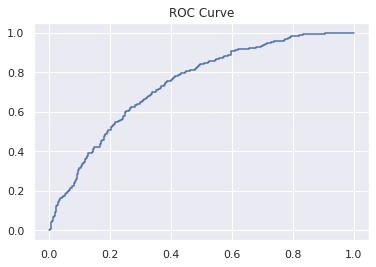

{'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
In-Sample Accuracy:  76.96 %
Out-of-Sample Accuracy:  74.86 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       473
           1       0.64      0.66      0.65       259

    accuracy                           0.75       732
   macro avg       0.73      0.73      0.73       732
weighted avg       0.75      0.75      0.75       732


AUC score 0.729509334160497


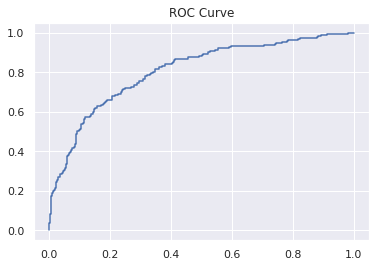

Model Summary Report
              precision    recall  f1-score   support

           0       0.95      0.75      0.84      3950
           1       0.23      0.64      0.34       470

    accuracy                           0.74      4420
   macro avg       0.59      0.69      0.59      4420
weighted avg       0.87      0.74      0.78      4420


AUC score 0.6929464045246432


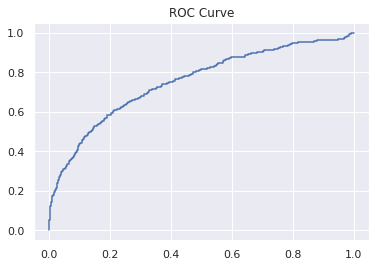

In [591]:
nc_rf_model, c_rf_model = my_evaluation(RandomForestClassifier, randomforest_parameters_grid)

### XGBoost

In [549]:
xgb_regression_parameters_grid={
#     'eta': [0.01,0.05,0.1,0.15,0.2,0.25],    #learning rate
#     adjust final
    'eta':[0.05],    #eta = 0.05 best for connect
    
    'n_estimators': [600],
    'gamma':[0.3], 
#     'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6],
#     'max_depth': [6], #very important initial state 6
    'max_depth': [5], #best for connect
#     'max_depth': [3, 4, 5, 6,7,8,9,10],
    
    'min_child_weight': [1],#very important initial state 1
    #min_child_weight =1 best for connect
#     'min_child_weight': [1, 2, 3, 4, 5, 6],
    'colsample_bytree': [1], 
    'colsample_bylevel': [1], 
    'subsample': [1],
    'reg_lambda': [1],
    'reg_alpha': [0],
#     'eval_metric':['error','auc'],
   'eval_metric':['error'],
    'objective':['binary:logistic']}

{'colsample_bylevel': 1, 'colsample_bytree': 1, 'eta': 0.05, 'eval_metric': 'error', 'gamma': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 600, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1}
In-Sample Accuracy:  98.55 %
Out-of-Sample Accuracy:  96.34 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3477
           1       0.79      0.49      0.60       211

    accuracy                           0.96      3688
   macro avg       0.88      0.74      0.79      3688
weighted avg       0.96      0.96      0.96      3688


AUC score 0.7401931719205558


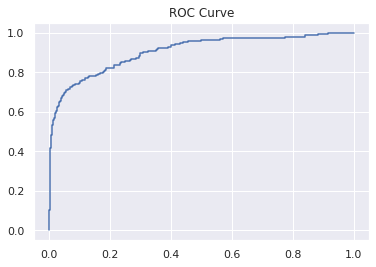

{'colsample_bylevel': 1, 'colsample_bytree': 1, 'eta': 0.05, 'eval_metric': 'error', 'gamma': 0.3, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 600, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1}
In-Sample Accuracy:  99.95 %
Out-of-Sample Accuracy:  86.48 % 

Model Summary Report
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       473
           1       0.85      0.75      0.80       259

    accuracy                           0.86       732
   macro avg       0.86      0.84      0.85       732
weighted avg       0.86      0.86      0.86       732


AUC score 0.8377031516566401


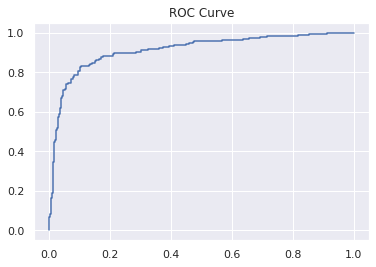

Model Summary Report
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      3950
           1       0.83      0.63      0.72       470

    accuracy                           0.95      4420
   macro avg       0.89      0.81      0.84      4420
weighted avg       0.94      0.95      0.94      4420


AUC score 0.8072986803124158


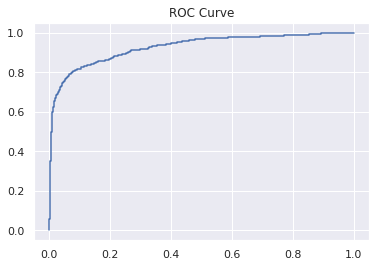

In [550]:
nc_xgb_model, c_xgb_model = my_evaluation(xgb.XGBClassifier, xgb_regression_parameters_grid)

### Tree Structure

In [592]:
dot_data = tree.export_graphviz(nc_rf_model.estimators_[3], out_file=None, 
                                feature_names = connect_data.drop(['status'], axis=1).columns, class_names = True,
                                filled = True, rounded = True) 
graph = graphviz.Source(dot_data) 
graph
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf('random forest.pdf')

True

In [587]:
import pydotplus

In [588]:
#for nonconnect model: nc_dt_model

dot_data = tree.export_graphviz(nc_dt_model, out_file=None, 
                                feature_names = connect_data.drop(['status'], axis=1).columns, class_names = True,
                                filled = True, rounded = True) 
graph = graphviz.Source(dot_data) 
graph

# graph = pydotplus.graph_from_dot_data(dot_data)
# graph.write_pdf('decision_tree.pdf')

True

In [553]:
# plot_learning_curve(model, title=model.__class__.__name__, X=nc_X_train,y=nc_Y_train)

###  Feature importance plotting

####  only random forest and Adaboost tree have feature importance
#### random forest model: nc_rd_model
#### adaboost tree model: nc_ada_tree_model

In [583]:
ada_feature_importance = nc_ada_tree_model.feature_importances_

rf_feature_importance = nc_rf_model.feature_importances_

dt_feature_importance = nc_dt_model.feature_importances_

xgb_feature_importance = nc_xgb_model.feature_importances_

ensemble_mean_feature_importance = (ada_feature_importance + rf_feature_importance + xgb_feature_importance) / 3

In [575]:
dt_model_importance = feature_importance_scatter_plot('Decision Tree',dt_feature_importance,nc_X_train)

In [576]:
ada_model_importance = feature_importance_scatter_plot('AdaBoostClassifier',ada_feature_importance,nc_X_train)

In [577]:
rf_model_importance = feature_importance_scatter_plot('RandomForest',rf_feature_importance,nc_X_train)

In [579]:
xgb_model_importance = feature_importance_scatter_plot('XGBoost',xgb_feature_importance,nc_X_train)

In [585]:
ensemble_mean_model_importance = feature_importance_scatter_plot('Ensemble Mean',ensemble_mean_feature_importance,nc_X_train)